<div style="background-image:url(images/header.svg); padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height: 250px">
    <div style="float:right; margin: 50px; padding: 20px; background:rgba(255,255,255,0.7); width: 50%; height: 150px">
        <div style="position:relative; top:50%; transform: translateY(-50%)">
            <div style="font-size: xx-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">Instaseis Tutorial</div>
            <div style="font-size: large; padding-top: 20px; color:rgba(0,0,0,0.5)">Part 3: Plot a Record Section</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Martin van Driel ([@martinvandriel](https://github.com/martinvandriel))
* Lion Krischer ([@krischer](https://github.com/krischer))
---

<img style="width:50%" src="images/logo.png">

## Advanced Exercise 1: Plot Record Section

Use `Instaseis` to calculate a record section of your choice.

![image](./images/record_section.png)

#### Notes

1. ObsPy Trace objects provide a function `times()` to conveniently get the time axis for plotting and the `normalize()` function to normalize seismograms to a common amplitude.
2. Use high pass filtering and deep sources if you want to enhance body waves
3. `np.linspace()` can help to generate equidistant stations
4. `obspy.taup.TauPyModel` can be used to compare with ray theoretical arrivals

-----

Basic lines to set up the notebook and some paths.

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import obspy
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)

Import Instaseis and open the database:

In [2]:
import instaseis
db = instaseis.open_db("data/database")

-----

## Examplary Solution

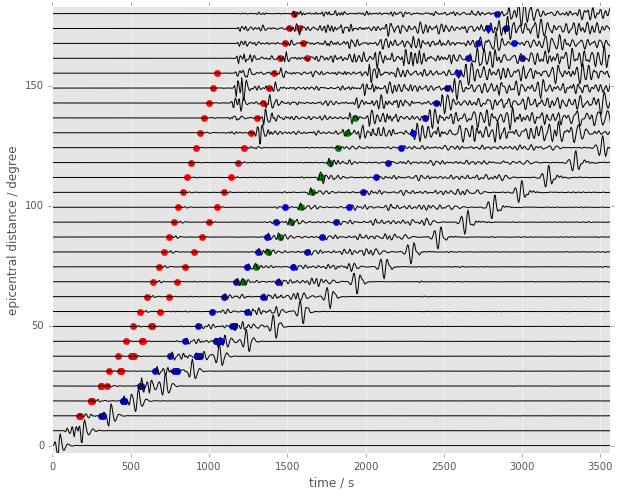

In [3]:
from obspy.taup import TauPyModel
from collections import defaultdict

m = TauPyModel(model="ak135")

# some paramters
depth_in_km = 150.
mindist = 0.
maxdist = 180.
numrec = 30
fmin = 0.02
fmax = 0.1
component = "Z"
phases = ["P", "PP", "Pdiff", "S", "SS", "PS"]
colors = ["r", "r", "r", "b", "b", "g"]

# define instaseis source
src = instaseis.Source.from_strike_dip_rake(
    latitude=0., longitude=0.,
    depth_in_m=depth_in_km * 1e3,
    M0=1e+21, strike=32., dip=62., rake=90.)

# storage for traveltimes
distances = defaultdict(list)
ttimes = defaultdict(list)

# loop over distances
for dist in np.linspace(mindist, maxdist, numrec):
    # define receiver
    rec = instaseis.Receiver(latitude=0, longitude=dist)

    # generate seismogram, filter and plot
    tr = db.get_seismograms(source=src, receiver=rec, components=[component])[0]
    tr.filter('highpass', freq=fmin)
    tr.filter('lowpass', freq=fmax)
    tr.normalize()
    plt.plot(tr.times(), tr.data * 5 + dist, color="black")
    
    # get traveltimes
    arrivals = m.get_travel_times(distance_in_degree=dist,
                                  source_depth_in_km=depth_in_km,
                                  phase_list=phases)
    for arr in arrivals:
        distances[arr.name].append(dist)
        ttimes[arr.name].append(arr.time)

# plot traveltimes
for color, phase in zip(colors, phases):
    plt.scatter(ttimes[phase], distances[phase], s=40, color=color)

plt.xlim(tr.times()[0], tr.times()[-1])
plt.ylim(mindist - 3, maxdist + 3)
plt.xlabel('time / s')
plt.ylabel('epicentral distance / degree')
plt.show()